In [1]:
import matplotlib.pyplot as plt

from Utils.UtilsViz import *
from Utils.DataExtractor import DataExtractor

In [2]:
# Read the data from the database
db_extractor = DataExtractor()
db = "kdd_2014"
tables = ["projects", "donations", "resources"]
table_map = {
    "projects" : ["projectid", "schoolid",
                  "primary_focus_subject", "primary_focus_area",
                  "poverty_level", "resource_type",
                  "total_price_including_optional_support",
                  "total_price_excluding_optional_support",
                  "year", "month", "day"], 
    "donations" : ["donationid", "projectid", "donation_total", "payment_method"], 
    "resources" : ["projectid", "resourceid", "vendorid", "vendor_name", 
                   "project_resource_type", "item_unit_price", "item_quantity"] 
}
data_map = {}
for table_name, table_cols in table_map.items():
    cols_to_select_str = ','.join(table_cols)
    query = "SELECT " + cols_to_select_str + " FROM " + table_name + ";"
    print("Executing Query :", query)
    data_map[table_name] = \
        db_extractor.read_db(db="kdd_2014", query=query, host="localhost", user="root", pwd="root")
    print("Extracted", data_map[table_name].shape[0], "rows of data from", table_name)

Executing Query : SELECT projectid,schoolid,primary_focus_subject,primary_focus_area,poverty_level,resource_type,total_price_including_optional_support,total_price_excluding_optional_support,year,month,day FROM projects;
Extracted 664098 rows of data from projects
Executing Query : SELECT donationid,projectid,donation_total,payment_method FROM donations;
Extracted 3097989 rows of data from donations
Executing Query : SELECT projectid,resourceid,vendorid,vendor_name,project_resource_type,item_unit_price,item_quantity FROM resources;
Extracted 3667217 rows of data from resources


In [ ]:
# To maintain time consistency, let's analyse the data only between the years 2003 and 2013 (inclusive).
years_to_ignore = [2000, 2001, 2002, 2014]
data_map["donations"] = data_map["donations"][~data_map["donations"]["year"].isin(years_to_ignore)]  
data_map["projects"] = data_map["projects"][~data_map["projects"]["year"].isin(years_to_ignore)]  

In [3]:
# Find the common columns between all dataframes
list_of_cols = []
for table_name, table in data_map.items():
    list_of_cols.append(list(table.columns))
common_col_list = list(find_common_cols(list_of_cols))
print("All three have these columns in common:", common_col_list)

All three have these columns in common: ['projectid']


In [4]:
merged_data = data_map["projects"].merge(data_map["donations"], how="outer", on=common_col_list)
merged_data = merged_data.merge(data_map["resources"], how="outer", on=common_col_list)

In [5]:
proj_fund_df = merged_data[["projectid", 
                            "total_price_including_optional_support",
                            "donation_total"]]
# Remove the projects that need no funding
proj_fund_df = proj_fund_df[proj_fund_df["total_price_including_optional_support"] > 0.0]
proj_fund_df["donation_total"] = proj_fund_df["donation_total"].fillna(value=0)
proj_fund_df["funding_target"] = proj_fund_df["donation_total"] /\
                                 proj_fund_df["total_price_including_optional_support"] 
# Snap the fully funded projects to 1
proj_fund_df["funding_target"][proj_fund_df["funding_target"] > 1] = 1
proj_fund_df.sort_values(by="funding_target", inplace=True, ascending=False)

D:\Softwares\Python36\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


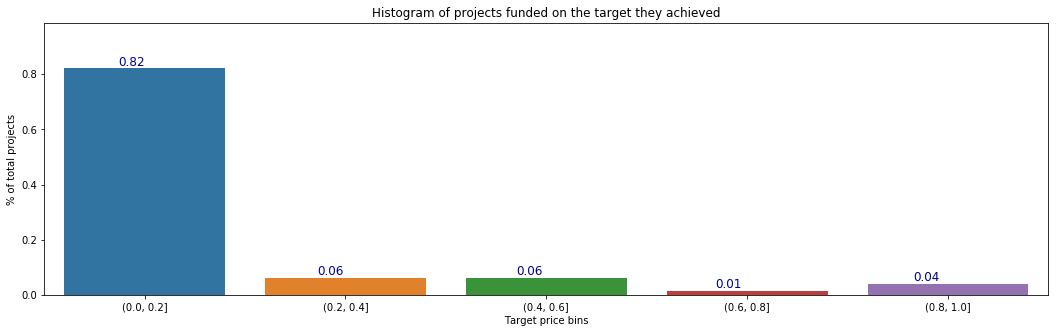

In [6]:
bins = [0, 0.20, 0.40, 0.60, 0.80, 1]
dfbins = pd.cut(proj_fund_df['funding_target'], bins)
agg_grp = proj_fund_df.groupby(dfbins, as_index=False)['funding_target'].agg(['count'])
agg_grp = agg_grp.reset_index(drop=False)
agg_grp.columns = ["price_bin", "num_projects"]
agg_grp["num_proj_%"] = agg_grp["num_projects"] / agg_grp["num_projects"].sum()

f, ax = plt.subplots(1, 1, figsize=(18, 5))
plot_bar(data=agg_grp, x="price_bin", y="num_proj_%", ax=ax, 
         title="Histogram of projects funded on the target they achieved",
         xlabel="Target price bins",
         ylabel="% of total projects")


In [7]:
proj_fund_80 = proj_fund_df[proj_fund_df["funding_target"] >= 0.8]

In [15]:
# What is the distribution of their target prices?
proj_fund_80["total_price_including_optional_support"].describe()

count    748816.000000
mean        710.761850
std        1117.516318
min          10.980000
25%         358.400000
50%         518.340000
75%         732.500000
max      100800.010000
Name: total_price_including_optional_support, dtype: float64

In [16]:
# What is the distribution of the donations they received?
proj_fund_80["donation_total"].describe()

count    748816.000000
mean        663.830034
std         997.515918
min          20.000000
25%         335.920000
50%         476.240000
75%         686.010000
max      100800.010000
Name: donation_total, dtype: float64

In [10]:
# Get a list of all the project IDs that were funded at least 80%
proj_80_idlist = proj_fund_80["projectid"].unique()
merged_fund_80 = merged_data[merged_data["projectid"].isin(proj_80_idlist)]

group_cols = ["projectid", "total_price_including_optional_support", "year", "month"]
select_cols = ["projectid", "total_price_including_optional_support", "year", "month", "donation_total"]
mergedgrp_80 = merged_fund_80[select_cols].groupby(by=group_cols, as_index=False).sum()

mergedgrp_80["funding_target"] = mergedgrp_80["donation_total"] /\
                                 mergedgrp_80["total_price_including_optional_support"] 
# Snap the fully funded projects to 1
mergedgrp_80["funding_target"][mergedgrp_80["funding_target"] > 1] = 1
mergedgrp_80.sort_values(by="funding_target", inplace=True, ascending=False) 

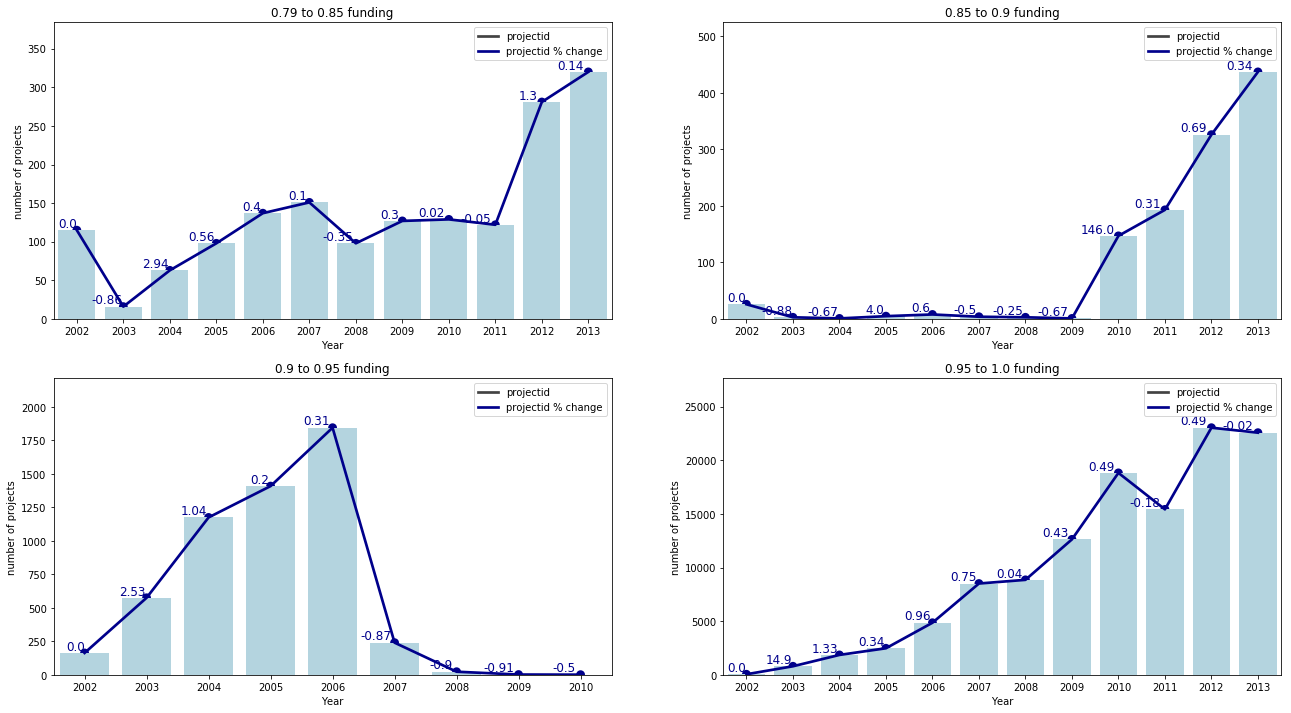

In [14]:
# Did projects reach their target as DonorsChoose matured over the years? 
bins = [0.79, 0.85, 0.9, 0.95, 1.0]
cols = ["projectid", "year"]
f, ax = plt.subplots(2, 2, figsize=(22, 12))
ax_list = [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]
for i in range(1, len(bins)):
    grp_subset = mergedgrp_80[(mergedgrp_80["funding_target"] > bins[i-1]) &
                                (mergedgrp_80["funding_target"] <= bins[i])]
    grp_subset = grp_subset[cols].groupby(by=["year"], as_index=False).count()
    plot_bar_timegraph(x="year", y="projectid", data=grp_subset, ax=ax_list[i-1],
                       title=str(bins[i-1]) + " to "+ str(bins[i]) + " funding", 
                       ylabel="number of projects", xlabel="Year")

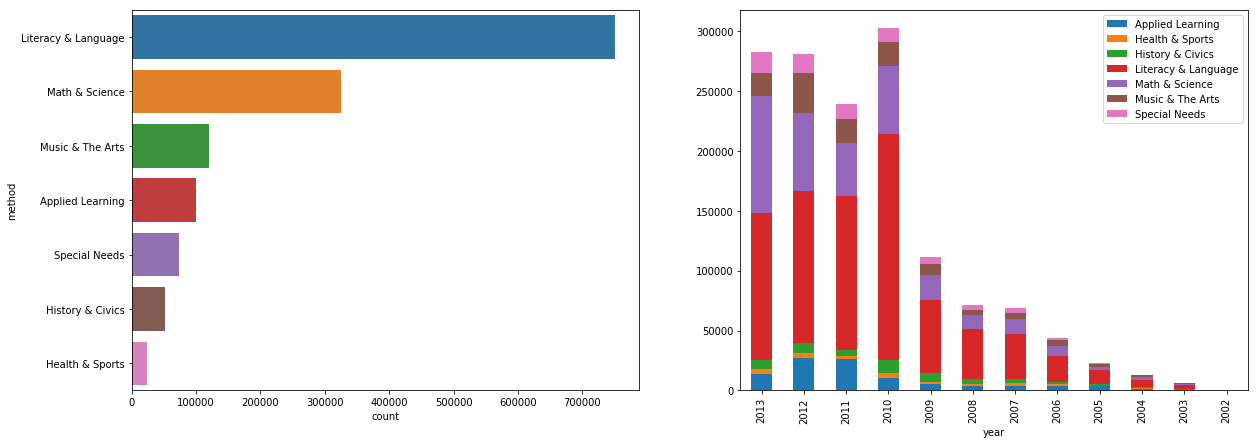

In [13]:
# What was the most popular focus area over the years to receive funding?
focus_area = merged_fund_80[["primary_focus_area", "year", "month"]]
focus_area_counts = focus_area["primary_focus_area"].value_counts().to_frame().reset_index(drop=False)
focus_area_counts.columns = ["method", "count"]

cols = ["primary_focus_area", "year"]
farea_year_group = group_and_sort(dataframe=focus_area[cols],  dummycol="primary_focus_area", groupbycol="year")
farea_year_group.sort_index(inplace=True, ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(20,7))
g = sns.barplot(x="count", y="method", data=focus_area_counts, ax=ax[0])
g = farea_year_group.plot(kind="bar", stacked=True, ax=ax[1]) 